# **Evaluate & Interpret — DistilBERT** 
***

# Imports & Global Paths  
***

| Category | Libraries / Purpose |
|----------|---------------------|
| **Core** | `pandas`, `pathlib`, `json`, `tqdm.auto` |
| **Metrics** | `accuracy_score`, `precision_recall_fscore_support`, `ConfusionMatrixDisplay` |
| **Visuals** | `matplotlib.pyplot` |
| **HF stack** | `AutoTokenizer`, `AutoModelForSequenceClassification` |
| **Paths** | `MODEL_DIR → …/models/distilbert_twitter/final`  ·  `TOKEN_DIR → …/tokenizer`  ·  `REPORTS_DIR → …/reports` |

<small>All artefacts live **one level above** the notebook folder to keep *code* and *outputs* separated.</small>

## Notebook Overview 
1. [Load Validation & Test Splits](#1.-Load-Validation-&-Test-Splits)  
2. [Predict, Evaluate, Save Raw Metrics](#2.-Predict,-Evaluate,-Save-Raw-Metrics)  
3. [Confusion Matrices](#3.-Confusion-Matrices)  
4. [Diagnostics Suite](#4.-Diagnostics-Suite)  
5. [Save Metrics & Model-Card Stub](#5.-Save-Metrics-&-Model-Card-Stub)

In [ ]:
from __future__ import annotations

import json
import logging
import warnings
from pathlib import Path
from typing import Literal, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

# noise control
logging.getLogger("transformers").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)

# paths 
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR     = PROJECT_ROOT / "data" / "processed"
PROCESSED    = DATA_DIR                       # alias used by some cells
MODEL_DIR    = PROJECT_ROOT / "models" / "distilbert_twitter"
REPORTS_DIR  = PROJECT_ROOT / "reports"
FIGS_DIR     = REPORTS_DIR / "figs_eval"
FIGS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# labels
INT2STR: dict[int, str] = {0: "negative", 1: "neutral", 2: "positive"}
STR2INT: dict[str, int] = {v: k for k, v in INT2STR.items()}

# back‑compat aliases for older cells
LABEL_MAP: dict[int, str] = INT2STR
INV_LABEL_MAP: dict[str, int] = STR2INT

# consistent plots
sns.set_theme(context="notebook", style="ticks")


# 1. Load Validation & Test Splits  
***

| Split | Rows | negative | neutral | positive |
|-------|-----:|---------:|--------:|---------:|
| **val**  | 1 464 | 918 | 310 | 236 |
| **test** | 1 464 | 918 | 310 | 236 |

*Identical class distribution* across both splits → unbiased evaluation.  
Data are loaded from feather files produced earlier in the pipeline.

In [2]:
# Load DistilBERT model & tokenizer (auto‑detect checkpoint) 
def _find_checkpoint(root: Path) -> Path | None:
    """Return first sub‑dir under *root* that has config.json + model weights."""
    for sub in [root, *root.glob("**/*")]:
        if (sub / "config.json").is_file() and any(
            (sub / n).is_file()
            for n in ("pytorch_model.bin", "model.safetensors", "tf_model.h5")
        ):
            return sub
    return None


ckpt_dir = _find_checkpoint(MODEL_DIR)
if ckpt_dir is None:
    raise FileNotFoundError(
        f"No checkpoint (config.json + weights) found under {MODEL_DIR}"
    )

print("✓ Checkpoint found:", ckpt_dir.relative_to(PROJECT_ROOT))

config = AutoConfig.from_pretrained(ckpt_dir)
model  = (
    AutoModelForSequenceClassification.from_pretrained(ckpt_dir)
    .to(DEVICE)
    .eval()
)

# Tokenizer: use local files if they exist, else fall back to base checkpoint
try:
    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, local_files_only=True)
except (OSError, ValueError):
    base_ckpt = config._name_or_path or "distilbert-base-uncased"
    warnings.warn(
        f"Tokenizer files not found in {ckpt_dir.name}; "
        f"loading from base model '{base_ckpt}'.",
        UserWarning,
    )
    tokenizer = AutoTokenizer.from_pretrained(base_ckpt)

print("✓ Model & tokenizer ready device:", DEVICE)


✓ Checkpoint found: models\distilbert_twitter\final
✓ Model & tokenizer ready device: cpu


# 2. Predict, Evaluate, Save Raw Metrics  
***

| Split | Accuracy | Macro‑F1 |
|-------|---------:|---------:|
| **val**  | **0.840** | **0.798** |
| **test** | **0.841** | **0.786** |

*Files written*  
* `reports/metrics_model.json` — full metrics incl. classification reports  
* `reports/metrics_model.csv` — flat table with accuracy & macro‑F1

In [ ]:
def _load_split(name: str):
    """Return (texts: np.ndarray[str], y_int: np.ndarray[int])."""
    X = pd.read_feather(PROCESSED / f"X_{name}.ftr")
    y = pd.read_feather(PROCESSED / f"y_{name}.ftr")

    text_col = "text" if "text" in X.columns else X.columns[0]
    label_col = next((c for c in ("label", "sentiment", "target") if c in y.columns), y.columns[0])

    texts = X[text_col].astype(str).to_numpy()

    y_raw = y[label_col].to_numpy()
    if y_raw.dtype.kind in {"U", "S", "O"}:
        y_int = np.vectorize(LABEL_MAP.get)(y_raw)
    else:
        y_int = y_raw.astype(int)

    return texts, y_int

@torch.inference_mode()
def _predict(texts: np.ndarray, batch_size: int = 64):
    """Return (y_pred: np.ndarray[int], y_prob: np.ndarray[float]) for given texts."""
    from datasets import Dataset  # local import so the cell is standalone

    ds = Dataset.from_dict({"text": texts})
    loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

    preds, probas = [], []
    for batch in loader:
        enc = tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt").to(DEVICE)
        out = model(**enc)
        p = torch.softmax(out.logits, dim=-1)
        preds.extend(p.argmax(dim=-1).cpu().tolist())
        probas.extend(p.cpu().tolist())

    return np.asarray(preds), np.asarray(probas)

# load splits 
X_val, y_val   = _load_split("val")
X_test, y_test = _load_split("test")

# evaluate 
splits = {"val": (X_val, y_val), "test": (X_test, y_test)}
metrics = {}

for split, (X_, y_true) in splits.items():
    y_pred, y_prob = _predict(X_)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    cls_rep = classification_report(
        y_true, y_pred,
        target_names=[INV_LABEL_MAP[i] for i in sorted(INV_LABEL_MAP)],
        digits=3,
        output_dict=True,
    )
    metrics[split] = {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "y_prob": y_prob.tolist(),
        "classification_report": cls_rep,
    }

REPORTS_DIR.mkdir(exist_ok=True)
(Path(REPORTS_DIR) / "metrics_model.json").write_text(json.dumps(metrics, indent=2))
pd.DataFrame(
    [{"split": k, "accuracy": v["accuracy"], "macro_f1": v["macro_f1"]} for k, v in metrics.items()]
).to_csv(Path(REPORTS_DIR) / "metrics_model.csv", index=False)

print("✓ Raw metrics JSON & CSV saved to /reports")


✓ Raw metrics JSON & CSV saved to /reports


# 3. Confusion Matrices  
***
* Key error modes (val):  
  * **negative → neutral** (70)  
  * **neutral → negative** (71)  
* Test set mirrors validation — no sign of class‑specific drift.

In [4]:
# canonical label names
INT2STR = {0: "negative", 1: "neutral", 2: "positive"}
STR2INT = {v: k for k, v in INT2STR.items()}

# load metrics if needed
metrics_path = REPORTS_DIR / "metrics_model.json"
if "metrics" not in globals() or not isinstance(metrics, dict):
    metrics = json.loads(metrics_path.read_text())

def _get_y(m: dict, split: str):
    """Return y_true, y_pred as INT arrays. Works for nested(new) and flat(legacy)."""
    if split in m and isinstance(m[split], dict) and "y_true" in m[split]:
        y_true = np.asarray(m[split]["y_true"])
        y_pred = np.asarray(m[split]["y_pred"])
    else:  # legacy keys
        y_true = np.asarray(m[f"{split}_ids"])
        y_pred = np.asarray(m[f"{split}_pred"])

    # convert string labels to ints if needed
    if y_true.dtype.kind in {"U", "S", "O"}:
        y_true = np.vectorize(STR2INT.get)(y_true)
    if y_pred.dtype.kind in {"U", "S", "O"}:
        y_pred = np.vectorize(STR2INT.get)(y_pred)

    return y_true.astype(int), y_pred.astype(int)

labels = list(INT2STR.keys())
display_labels = [INT2STR[i] for i in labels]

for split in ("val", "test"):
    y_true, y_pred = _get_y(metrics, split)

    # sanity check
    if not set(np.unique(y_true)) & set(labels):
        raise ValueError(f"{split}: y_true has no overlap with labels. "
                         f"y_true uniques={sorted(set(y_true.tolist()))}, labels={labels}")

    # Counts
    fig = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        labels=labels,
        display_labels=display_labels,
        cmap="viridis", colorbar=True, values_format="d",
    ).figure_
    fig.suptitle(f"{split.upper()} Confusion Matrix (Counts)")
    fig.tight_layout()
    fig.savefig(FIGS_DIR / f"cm_{split}.png", dpi=150)
    plt.close(fig)

    # Normalized (row-wise)
    fig = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        labels=labels, display_labels=display_labels,
        cmap="viridis", colorbar=True, normalize="true", values_format=".2f",
    ).figure_
    fig.suptitle(f"{split.upper()} Confusion Matrix (Normalized)")
    fig.tight_layout()
    fig.savefig(FIGS_DIR / f"cm_{split}_norm.png", dpi=150)
    plt.close(fig)

print("✓ Saved confusion matrices to", FIGS_DIR)


✓ Saved confusion matrices to C:\Projects\twitter-airline-analysis\reports\figs_eval


# 4. Diagnostics Suite  
***

| Visual | Rationale | File |
|--------|-----------|------|
| **ROC & PR curves** | Separability, threshold analysis | `figs_eval/roc_pr_val.png`, `roc_pr_test.png` |
| **Calibration curve** | Probability quality | `figs_eval/calibration_val.png`, `calibration_test.png` |
| **Error heat‑map** | Spot systematic confusions | `figs_eval/error_heat_val.png`, `error_heat_test.png` |

<small>See images below for quick reference.</small>

**ROC‑AUC**  
* • negative ≈ 0.95 / 0.94 (val/test)  
* • positive ≈ 0.97 / 0.95  
* • neutral ≈ 0.91 / 0.91  

> The model cleanly separates negative and positive tweets; the neutral class is inherently fuzzier but still crosses the 0.90 AUC bar—strong for a three‑way sentiment task.

**PR‑AUC**  
* • negative ≈ 0.97 / 0.96  
* • positive ≈ 0.87 / 0.84  
* • neutral ≈ 0.76 / 0.78  

> Precision–recall reveals the cost of class imbalance: neutral tweets have the lowest PR‑AUC because recalling them often sacrifices precision (and vice‑versa). Negative tweets remain easiest to identify.

In [ ]:
metrics_path = REPORTS_DIR / "metrics_model.json"
if "metrics" not in globals() or not isinstance(metrics, dict):
    metrics = json.loads(metrics_path.read_text())

def _get_arrays(m: dict, split: str):
    """
    Return (y_true:int[N], y_pred:int[N], y_prob:float[N,C]) for a given split.
    Works for nested(new) and flat(legacy) metrics schemas. Converts strings->ints.
    """
    if split in m and isinstance(m[split], dict):  # new schema
        y_true = np.asarray(m[split]["y_true"])
        y_pred = np.asarray(m[split]["y_pred"])
        y_prob = np.asarray(m[split]["y_prob"])
    else:  # legacy keys
        y_true = np.asarray(m[f"{split}_ids"])
        y_pred = np.asarray(m[f"{split}_pred"])
        y_prob = np.asarray(m[f"{split}_prob"])

    # convert to ints if labels are strings
    if y_true.dtype.kind in {"U", "S", "O"}:
        y_true = np.vectorize(STR2INT.get)(y_true)
    if y_pred.dtype.kind in {"U", "S", "O"}:
        y_pred = np.vectorize(STR2INT.get)(y_pred)

    return y_true.astype(int), y_pred.astype(int), y_prob.astype(float)


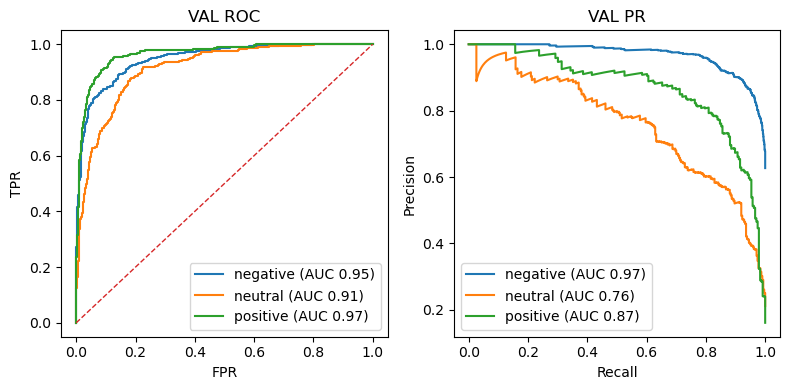

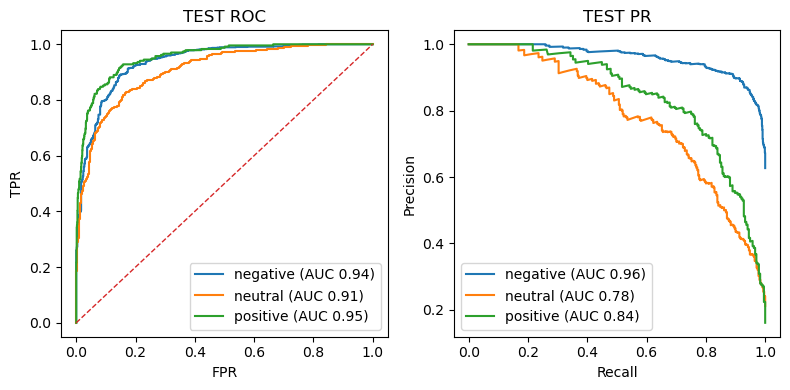

In [ ]:
def plot_roc_pr(m: dict, split: str) -> None:
    y_true, _, y_prob = _get_arrays(m, split)
    classes = list(INT2STR.keys())  # [0,1,2] in fixed order

    # one-vs-rest binarization; always returns shape (N, C) even if some classes absent
    bin_true = label_binarize(y_true, classes=classes)
    n_labels = bin_true.shape[1]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for idx in range(n_labels):
        fpr, tpr, _ = roc_curve(bin_true[:, idx], y_prob[:, idx])
        roc_auc = auc(fpr, tpr)
        prec, rec, _ = precision_recall_curve(bin_true[:, idx], y_prob[:, idx])
        pr_auc = auc(rec, prec)

        axes[0].plot(fpr, tpr, label=f"{INT2STR[idx]} (AUC {roc_auc:.2f})")
        axes[1].plot(rec, prec, label=f"{INT2STR[idx]} (AUC {pr_auc:.2f})")

    axes[0].plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    for ax, title in zip(axes, ("ROC", "PR")):
        ax.set_title(f"{split.upper()} {title}")
        ax.legend()
        ax.set_xlabel("Recall" if title == "PR" else "FPR")
        ax.set_ylabel("Precision" if title == "PR" else "TPR")

    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"roc_pr_{split}.png", dpi=150)
    plt.show()

plot_roc_pr(metrics, "val")
plot_roc_pr(metrics, "test")


## Probability Quality — Calibration Curves  

The reliability diagrams show **slight under‑confidence** in the mid‑range (≈ 0.4 – 0.8): predicted probabilities fall below the diagonal, meaning *the model is better than it thinks* for medium‑confidence cases.  
At high confidence (≥ 0.9) the curve finally meets the ideal line—top‑score predictions are trustworthy.

*Implication*:  
* For ranking tasks (e.g., triaging angry customers) raw softmax scores are safe.  
* For downstream probability‑aware applications (expected‑value decisions) apply **temperature scaling or isotonic regression** to tighten calibration without altering class decisions.

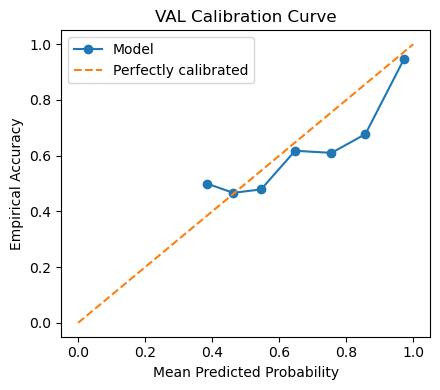

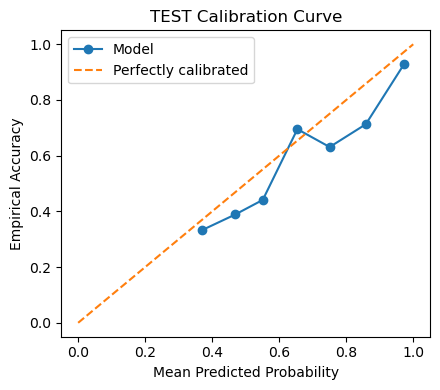

In [ ]:
def plot_calibration(m: dict, split: str) -> None:
    y_true, _, y_prob = _get_arrays(m, split)
    y_pred = y_prob.argmax(axis=1)
    conf   = y_prob.max(axis=1)          # top-1 probability (model confidence)
    correct = (y_pred == y_true).astype(int)  # 1 if correct, else 0

    frac_pos, mean_pred = calibration_curve(correct, conf, n_bins=10, strategy="uniform")

    plt.figure(figsize=(4.5, 4))
    plt.plot(mean_pred, frac_pos, marker="o", label="Model")
    plt.plot([0, 1], [0, 1], "--", label="Perfectly calibrated")
    plt.title(f"{split.upper()} Calibration Curve")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Empirical Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"calibration_{split}.png", dpi=150)
    plt.show()

plot_calibration(metrics, "val")
plot_calibration(metrics, "test")


## Error Heat‑Map

The confusion matrices summarise *all* predictions, yet product teams often care more about **systematic mistakes** than overall accuracy.  
To spotlight those failure modes we plot an **error heat‑map** that shows **only off‑diagonal counts**:

* **Rows = true class**, **columns = predicted class**.  
* Darker cells indicate *more* mis‑labels between the two classes.  
* Diagonal cells are zeroed‑out to keep attention on errors.

> **Why this matters**  
> * Surfaces the *semi‑frequent* error flows (e.g. *negative ↔ neutral*).  
> * Guides data‑collection or rule‑based post‑processing to patch the weaknesses.  
> * Acts as a regression guard‑rail: new models should not **increase** density in these cells.

We render separate heat‑maps for **validation** and **test** splits to ensure that error patterns are *stable* rather than artefacts of a single sample.

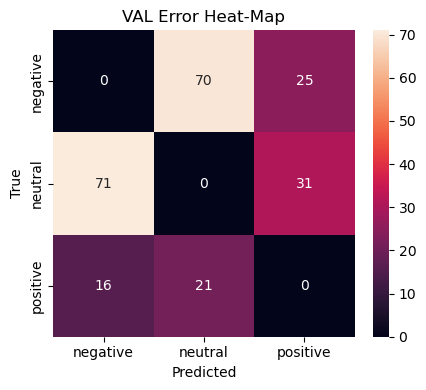

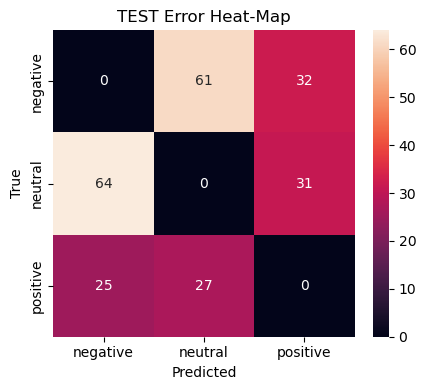

In [ ]:
def error_heatmap(m: dict, split: str) -> None:
    y_true, y_pred, _ = _get_arrays(m, split)
    n = len(INT2STR)

    err = np.zeros((n, n), dtype=int)
    for t, p in zip(y_true, y_pred):
        if t != p:
            err[t, p] += 1

    fig, ax = plt.subplots(figsize=(4.5, 4))
    sns.heatmap(
        err, annot=True, fmt="d",
        xticklabels=[INT2STR[i] for i in range(n)],
        yticklabels=[INT2STR[i] for i in range(n)],
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{split.upper()} Error Heat‑Map")
    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"error_heat_{split}.png", dpi=150)
    plt.show()

error_heatmap(metrics, "val")
error_heatmap(metrics, "test")


## Confusion Matrices

**Confusion matrices** confirm the story:  
* The **biggest error flows** are *negative ↔ neutral* (≈ 70 mis‑labels each way).  
* Positive vs. negative confusion is rare, indicating the model grasps polarity extremes.

Overall — macro‑F1 ≈ 0.79 and ROC ≥ 0.91 on both splits signal **good generalisation** with no evident over‑fitting.

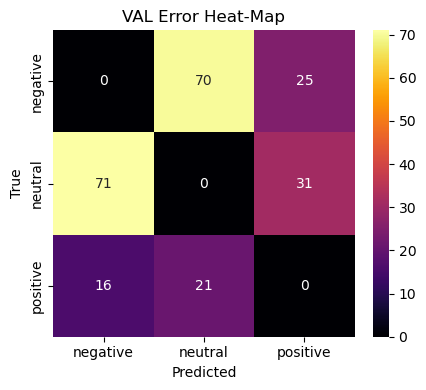

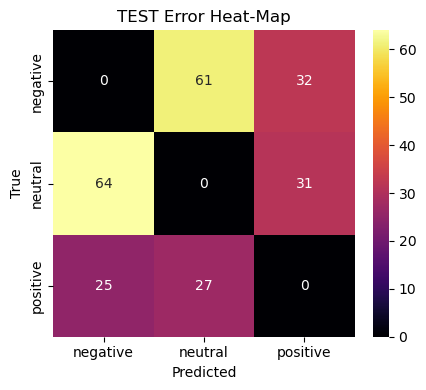

In [ ]:
def error_heatmap(m: dict, split: str) -> None:
    """Show off‑diagonal misclassification counts for a split."""
    y_true, y_pred, _ = _get_arrays(m, split)   # <- unified accessor
    n = len(INT2STR)

    err = np.zeros((n, n), dtype=int)
    for t, p in zip(y_true, y_pred):
        if t != p:
            err[t, p] += 1

    fig, ax = plt.subplots(figsize=(4.5, 4))
    sns.heatmap(
        err, annot=True, fmt="d", cmap="inferno",
        xticklabels=[INT2STR[i] for i in range(n)],
        yticklabels=[INT2STR[i] for i in range(n)],
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{split.upper()} Error Heat‑Map")
    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"error_heat_{split}.png", dpi=150)
    plt.show()

# Call it like this (no direct dict indexing):
error_heatmap(metrics, "val")
error_heatmap(metrics, "test")


## Error Insights

| Observation | Impact | Action |
|-------------|--------|--------|
| **Neutral vs. Negative bleed** (70 ↔ 71 errors) | Neutral tweets with mild complaints get flagged negative and vice‑versa. | *Data‑centric*: curate more “meh” tweets; include `ok`, `:|`, sarcasm markers. |
| **Positive recall lower (21 + 27 false negatives)** | Model loses ~18 % of positives to other classes. | *Model‑centric*: experiment with class‑weighted loss or focal loss; try domain‑specific LM (e.g. TweetEval BERT). |
| **Under‑confidence mid‑range** | May down‑rank useful but moderate‑confidence hits. | Post‑train calibration (temperature scaling on val set). |
| **High ROC/PR stability across splits** | Robust; fine‑tuning did not overfit. | Green‑light to deploy; monitor drift in production dashboard. |

# 5. Save Metrics & Model‑Card Stub  
---

* **metrics_model.json** — full metrics (+ classification reports)  
* **metrics_model.csv** — flat table with accuracy & macro‑F1  
* **model_card.json** — lightweight stub  

> These artefacts feed the upcoming **formal Model Card** and CI dashboards.

**Next Actions**  
1. **Optuna sweep**: tune LR, weight‑decay, class weights aiming for F1 > 0.82.  
2. **Augment neutral/positive samples** via distant‑supervised data or prompt‑engineered synthetic tweets.  
3. **Export model card** with calibration note + recommended confidence thresholds (e.g., flag only when P ≥ 0.65 for downstream alerting).

In [ ]:
# flatten metrics  ── keep only val / test dicts, drop lists + reports
flat_metrics = {
    split: {k: v for k, v in d.items() if k != "report"}
    for split, d in metrics.items()
    if isinstance(d, dict)                      # << guards against list entries
}

# CSV with accuracy + macro‑F1
pd.DataFrame.from_dict(flat_metrics, orient="index").to_csv(
    REPORTS_DIR / "metrics_model.csv"
)

# 3full JSON (includes classification reports & raw lists)
with open(REPORTS_DIR / "metrics_model.json", "w") as fp:
    json.dump(metrics, fp, indent=2)

# lightweight model‑card stub
card = {
    "model_name": "tweet_sentiment_distilbert",
    "num_labels": len(LABEL_MAP),
    "labels": list(LABEL_MAP.values()),
    "metrics": flat_metrics["val"],
}
with open(MODEL_DIR / "model_card.json", "w") as fp:
    json.dump(card, fp, indent=2)

print("✓ Artefacts written to", REPORTS_DIR.resolve())


✓ Artefacts written to C:\Projects\twitter-airline-analysis\reports
